## Proof of Concept Workflow: Identifying potential candidates for data collection

Created: 9 November 2023<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
df = pd.read_excel(interim_dir+'final_landscape_with_predicted_NAMs_091123.xlsx', index_col = [0] )


In [4]:
df.final_centroid.nunique()

90

In [5]:
universe_ids = df.dtxsid.tolist()

In [6]:
len(universe_ids)

15414

In [7]:
df.shape

(15414, 124)

In [8]:
import sqlalchemy as sa

In [9]:
username = 'grace'
password = 'graceSQL'
host = '192.168.11.210'

In [10]:
toxval_db = sa.create_engine(f"""mysql+pymysql://{username}:{password}@{host}/toxval94nov""")

In [11]:
txval = pd.read_sql('''select * from toxval94nov where toxval_type in ('NOAEL', 'LEL', 'NEL','LOAEL', 'NOAEC', 'LOAEC', 'NOEL', 'LOEL') and study_type in ('short-term','subchronic', 'chronic', 'developmental', 'reproduction','neurotoxicity', 'neurotoxicity short-term','neurotoxicity subchronic', 'neurotoxicity chronic',  'reproduction developmental','repeat dose', 'repeat dose other', 'immunotoxicity',\
       'reproduction developmental', 'chronic cancer','developmental neurotoxicity', 'carcinogenicity', 'short-term') and exposure_route in ('oral', 'inhalation', 'Inhalation') and toxval_units in ('mg/m3', 'mg/kg-day') ''', toxval_db)

In [12]:
txval.study_type.unique()

array(['short-term', 'subchronic', 'chronic', 'developmental',
       'reproduction', 'neurotoxicity', 'neurotoxicity short-term',
       'neurotoxicity subchronic', 'reproduction developmental',
       'immunotoxicity', 'neurotoxicity chronic', 'repeat dose other'],
      dtype=object)

In [13]:
txval.columns

Index(['index', 'toxval_id', 'source_hash', 'source_table', 'chemical_id',
       'dtxsid', 'source', 'subsource', 'source_url', 'subsource_url',
       ...
       'Unnamed: 99', 'Unnamed: 100', 'Unnamed: 101', 'Unnamed: 102',
       'Unnamed: 103', 'Unnamed: 104', 'Unnamed: 105', 'Unnamed: 106',
       'Unnamed: 107', 'Unnamed: 108'],
      dtype='object', length=110)

In [14]:
universe_tox = df[df['dtxsid'].isin(txval.dtxsid.tolist())]

In [15]:
analogue_df = txval[txval['dtxsid'].isin(df.dtxsid.unique())]

In [16]:
analogue_df.toxval_type.unique()

array(['NOAEL', 'LOAEL', 'NOEL', 'LOEL', 'LEL', 'NOAEC', 'LOAEC', 'NEL'],
      dtype=object)

In [17]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt',
       ...
       'pred_Immune', 'pred_NR_ESR1', 'pred_NR_NRF2', 'pred_NR_PPAR',
       'pred_NR_PXR', 'pred_NR_RXR', 'pred_No flag', 'pred_TK_PlasBind',
       'pred_ZF', 'pred_hDIO1'],
      dtype='object', length=124)

In [18]:
landscape_dict = {k:v for k,v in zip(df['dtxsid'], df['group_str'])}

In [19]:
analogue_df['group_str'] = analogue_df['dtxsid'].replace(landscape_dict)

/tmp/ipykernel_93041/3439423276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analogue_df['group_str'] = analogue_df['dtxsid'].replace(landscape_dict)


In [20]:
iv_tox = analogue_df.groupby(['dtxsid', 'study_type']).size().reset_index().pivot_table(index = 'dtxsid', columns = 'study_type', values = 0)

In [21]:
iv_tox.columns.name = None

<Axes: ylabel='dtxsid'>

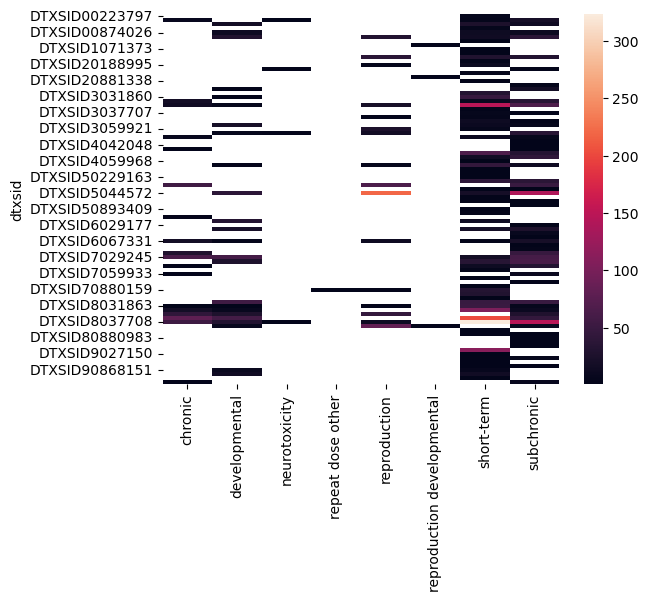

In [22]:
sns.heatmap(iv_tox)

In [23]:
iv_tox_v1 = iv_tox.applymap(lambda x: 1 if pd.notnull([x]) else np.nan )

In [24]:
iv_tox_v1

,chronic,developmental,neurotoxicity,repeat dose other,reproduction,reproduction developmental,short-term,subchronic
dtxsid,,,,,,,,
DTXSID00223797,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
DTXSID0034774,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0
DTXSID0061826,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0
DTXSID0067848,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
DTXSID00874026,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...
DTXSID9059834,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
DTXSID90868151,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
DTXSID90870315,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN


Lists

In [25]:
import glob

In [26]:
files = glob.glob(external_dir+'/*mapped_070423.xlsx', 
                   recursive = True)
for file in files:
    print(file)

/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070423.xlsx
/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070423.xlsx


In [27]:
def read_file(fs):
    mylst = []
    for f in fs:
        df = pd.read_excel(f)
        #df.drop(['Unnamed: 0'], axis = 1, inplace = True)
        df['source'] = f
        mylst.append(df)
        mydfs = pd.concat(mylst)
    return mydfs

In [28]:
lists = read_file(files)

In [29]:
lists['source'].unique()

array(['/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070423.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070423.xlsx'],
      dtype=object)

In [30]:
source_dict = {'/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070423.xlsx' : 'TRI-ONSITE',
       '/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070423.xlsx': 'PROD_DATA',
       '/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070423.xlsx': 'DISCHARGE',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070423.xlsx' : 'TRI_WASTE',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070423.xlsx' : 'DRINKING_WATER-UCMR',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070423.xlsx' : 'DRINKING_WATER',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070423.xlsx' : 'TRI-OFFSITE'}

In [31]:
lists['source']  = lists['source'].replace(source_dict)

In [32]:
lists.DTXSID.nunique()

348

In [33]:
lists = lists.iloc[:,:9]

In [34]:
lists.columns

Index(['Chemical Name', 'CAS Number', 'INPUT', 'FOUND_BY', 'DTXSID',
       'PREFERRED_NAME', 'CASRN', 'SMILES', 'source'],
      dtype='object')

In [35]:
lists

,Chemical Name,CAS Number,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,SMILES,source
0,"1,1,2,2-Tetrahydroperfluorodecyl acrylate",27905-45-9,27905-45-9,CASRN,DTXSID5067348,2-(Perfluorooctyl)ethyl acrylate,27905-45-9,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,TRI-ONSITE
1,"1,1,2,2-Tetrahydroperfluorododecyl acrylate",17741-60-5,17741-60-5,CASRN,DTXSID9037743,2-(Perfluorodecyl)ethyl acrylate,17741-60-5,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,TRI-ONSITE
2,"1,1,2,2-Tetrahydroperfluorohexadecyl acrylate",34362-49-7,34362-49-7,CASRN,DTXSID6067836,"1,1,2,2-Tetrahydroperfluorohexadecyl acrylate",34362-49-7,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,TRI-ONSITE
3,"1,1,2,2-Tetrahydroperfluorotetradecyl acrylate",34395-24-9,34395-24-9,CASRN,DTXSID5067841,(Perfluorododecyl)ethyl 2-propenoate,34395-24-9,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,TRI-ONSITE
4,"1,1-Dichloro-1,2,2,3,3-pentafluoropropane (HCF...",13474-88-9,13474-88-9,CASRN,DTXSID1042029,"1,1-Dichloro-1,2,2,3,3-pentafluoropropane",13474-88-9,FC(F)C(F)(F)C(F)(Cl)Cl,TRI-ONSITE
...,...,...,...,...,...,...,...,...,...
63,Tetrafluoroethylene,116-14-3,116-14-3,CASRN,DTXSID6021325,Tetrafluoroethylene,116-14-3,FC(F)=C(F)F,TRI-OFFSITE
64,"Thiols, C10-20, γ-ω-perfluoro",68140-21-6,68140-21-6,CASRN,DTXSID90881906,Perfluoroalkyl(C8-18)ethyl mercaptan,68140-21-6,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,TRI-OFFSITE
65,"Thiols, C4-10, γ-ω-perfluoro",68140-18-1,68140-18-1,CASRN,DTXSID90881901,Perfluoroalkyl (C2-C8)ethyl mercaptan,68140-18-1,"FC(F)(F)C(F)(F)CCS |lp:0:3,2:3,3:3,5:3,6:3,9:2...",TRI-OFFSITE
66,"Thiols, C6-12, γ-ω-perfluoro",68140-20-5,68140-20-5,CASRN,DTXSID30881905,Perfluoroalkyl(C4-10)ethyl mercaptan,68140-20-5,"FC(F)(F)C(F)(F)CCS |lp:0:3,2:3,3:3,5:3,6:3,9:2...",TRI-OFFSITE


In [36]:
analytes = pd.read_excel(external_dir+'PFAS with Validated Analytical Methods 533 and 537.xlsx')

In [37]:
analytes['source'] = 'ANALYTICAL_MTHDS'

In [38]:
analytes = analytes[['DTXSID', 'PREFERRED NAME', 'CASRN','SMILES','source']]

In [39]:
analytes.columns = ['DTXSID', 'PREFERRED_NAME', 'CASRN', 'SMILES', 'source']

In [40]:
lists = pd.concat([lists,  analytes])

In [41]:
priority_lists = lists.groupby(['DTXSID', 'source']).size().reset_index().pivot_table(index = 'DTXSID', columns = 'source', values = 0)

In [42]:
priority_lists = priority_lists.applymap(lambda x: 1 if pd.notnull([x]) else np.nan )

In [43]:
universe = pd.merge(df, iv_tox_v1, left_on = 'dtxsid', right_on = iv_tox.index, how = 'left')

In [44]:
priority_lists = priority_lists.reset_index()

In [45]:

priority_lists.rename(columns = {'DTXSID': 'dtxsid'}, inplace = True)


In [46]:
universe.shape

(15414, 132)

In [47]:
universe1 =  pd.merge(universe, priority_lists, on = 'dtxsid',  how = 'left')

In [48]:
universe1.shape

(15414, 140)

In [49]:
pubmed = pd.read_csv(interim_dir+'pubmed_counts_081123.csv')

In [50]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12455 entries, 0 to 12454
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     12455 non-null  int64 
 1   dtxsid         12455 non-null  object
 2   article_count  12455 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 292.0+ KB


In [51]:
pubmed['pubmed_avail'] = pubmed['article_count'].apply(lambda x: 1 if x>=1 else np.nan )

In [52]:
pubmed

,Unnamed: 0,dtxsid,article_count,pubmed_avail
0,0,DTXSID6071908,0,NaN
1,1,DTXSID8071358,0,NaN
2,2,DTXSID1071907,0,NaN
3,3,DTXSID001026645,1,1.0
4,4,DTXSID301026644,0,NaN
...,...,...,...,...
12450,12450,DTXSID60781565,0,NaN
12451,12451,DTXSID40660107,0,NaN
12452,12452,DTXSID101034031,0,NaN
12453,12453,DTXSID60897190,0,NaN


In [53]:
pubmed = pubmed[['dtxsid', 'pubmed_avail']].drop_duplicates()

In [54]:
pubmed['pubmed_avail'].value_counts()

1.0    4611
Name: pubmed_avail, dtype: int64

In [55]:
universe2 = pd.merge(universe1, pubmed, on = 'dtxsid',  how = 'left')

In [56]:
universe2.shape

(15414, 141)

In [58]:
writer = pd.ExcelWriter(interim_dir+'final_updated_universe_101123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

universe2.to_excel(writer)

writer.close()

In [66]:
universe2.TSCA_STATUS.unique()

array(['inactive', 'active', 'unclassified'], dtype=object)

In [67]:
universe2.columns.tolist()

['dtxsid',
 'DSSTox_QC-Level',
 'Substance_Name',
 'Substance_CASRN',
 'Substance_Type',
 'smiles',
 'Structure_InChI',
 'Structure_InChIKey',
 'Structure_Formula',
 'Structure_MolWt',
 'Structure_SMILES_2D-QSAR',
 'Canonical_QSARr',
 'TSCA_STATUS',
 'chain_length',
 'category',
 'MolWeight',
 'LogP_pred',
 'LogP_predRange',
 'AD_LogP',
 'AD_index_LogP',
 'Conf_index_LogP',
 'MP_pred',
 'MP_predRange',
 'AD_MP',
 'AD_index_MP',
 'Conf_index_MP',
 'BP_pred',
 'BP_predRange',
 'AD_BP',
 'AD_index_BP',
 'Conf_index_BP',
 'LogVP_pred',
 'VP_predRange',
 'AD_VP',
 'AD_index_VP',
 'Conf_index_VP',
 'LogWS_pred',
 'WS_predRange',
 'AD_WS',
 'AD_index_WS',
 'Conf_index_WS',
 'LogHL_pred',
 'HL_predRange',
 'AD_HL',
 'AD_index_HL',
 'Conf_index_HL',
 'ID',
 'tsca_match',
 'subcategory',
 'cluster',
 'cluster_centroid',
 'centroid_x',
 'centroid2',
 'centroid_y',
 'analogues',
 'Dist',
 'level2_cluster_centroid',
 'cluster_d',
 'lvl2_centroid',
 'lvl2_centroid2',
 'lvl2_analogues',
 'lvl2_Dist',

In [68]:
X = universe2[['group_str',
 'chronic',
 'developmental',
 'neurotoxicity',
 'repeat dose other',
 'reproduction',
 'reproduction developmental',
 'short-term',
 'subchronic',
 'ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'CDR2020_STATUS',
 'pubmed_avail'
 ]].replace(np.nan, 0)

In [69]:
X1 =X.groupby('group_str').agg('max')

In [70]:
X1.head()

,chronic,developmental,neurotoxicity,repeat dose other,reproduction,reproduction developmental,short-term,subchronic,ANALYTICAL_MTHDS,DISCHARGE,DRINKING_WATER,DRINKING_WATER-UCMR,PROD_DATA,TRI-OFFSITE,TRI-ONSITE,TRI_WASTE,CDR2020_STATUS,pubmed_avail
group_str,,,,,,,,,,,,,,,,,,
"('FASA based PFAA precursors', 'gte7', nan, nan)",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
"('FASA based PFAA precursors', 'lt7', nan, nan)",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
"('Fluorotelomer PFAA precursors', 'gte7', nan, nan)",0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
"('Fluorotelomer PFAA precursors', 'lt7', 1.0, nan)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 1.0)",0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [71]:
tsca_only = df[df['TSCA_STATUS'] != 'unclassified']

In [72]:
tsca_only['group_str'].nunique()

71

In [79]:
universe2.columns.tolist()[124:132]

['chronic',
 'developmental',
 'neurotoxicity',
 'repeat dose other',
 'reproduction',
 'reproduction developmental',
 'short-term',
 'subchronic']

In [80]:
data_poor_cats = []
for i,group in universe2.groupby('group_str'):
    subset = group[universe2.columns.tolist()[124:132]]
    if subset.sum(axis = 0, skipna = True).any() ==0:
        data_poor_cats.append(i)

In [81]:
len(data_poor_cats)

58

In [82]:
tsca_act = []
for i, group in universe2.groupby('group_str'):
    subset =  group['TSCA_STATUS']
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if (subset.eq('active')).any():
        tsca_act.append(i)

In [83]:
len(tsca_act)

57

In [84]:
universe2.columns.tolist()[132:] + ['CDR2020_STATUS']  

['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'pubmed_avail',
 'CDR2020_STATUS']

In [85]:
em = ['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'pubmed_avail',
 'CDR2020_STATUS']

In [85]:
#universe2.columns.tolist()[125:]

In [86]:
on_em = []
for i, group in universe2.groupby('group_str'):
    subset =  group[universe2.columns.tolist()[132:] + ['CDR2020_STATUS']]
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if subset.sum(axis = 0, skipna = True).any() >=1:
        on_em.append(i)

In [87]:
len(on_em)

86

In [88]:
em2 = ['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'CDR2020_STATUS']

In [89]:
on_em2 = []
for i, group in universe2.groupby('group_str'):
    subset =  group[em2]
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if subset.sum(axis = 0, skipna = True).any() >=1:
        on_em2.append(i)

In [90]:
len(on_em2)

44

In [91]:
not_tsca_cats = []
for i, group in universe2.groupby('group_str'):
    subset =  group['TSCA_STATUS']
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if (subset.eq('unclassified')).all():
        not_tsca_cats.append(i)

In [92]:
len(not_tsca_cats)

19

In [93]:
tsca_cats = [e for e in universe2.group_str.unique().tolist() if e not in not_tsca_cats]


In [94]:
len(tsca_cats)

71

In [95]:
data_poor_tsca = [e for e in data_poor_cats if e in tsca_cats]

In [96]:
len(data_poor_tsca)

39

In [97]:
data_poor_tsca_act = [e for e in data_poor_cats if e in tsca_act]

In [98]:
len(data_poor_tsca_act)

25

In [99]:
#data_poor_tsca_act

In [100]:
len([e for e in on_em2 if e in data_poor_tsca])

16

In [101]:
len([e for e in on_em if e in data_poor_tsca])

37

In [102]:
len([e for e in on_em2 if e in data_poor_tsca_act])

14

In [103]:
len([e for e in on_em if e in data_poor_tsca_act])

25

In [104]:
[e for e in on_em2 if e in data_poor_tsca_act]

["('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 2.0)",
 "('Other aliphatics', 'gte7', 1.0, nan)",
 "('Other aliphatics', 'gte7', 3.0, 2.0)",
 "('Other aliphatics', 'gte7', 3.0, 3.0)",
 "('Other aliphatics', 'lt7', 1.0, 2.0)",
 "('PFAA precursors', 'gte7', nan, nan)",
 "('PFAA precursors', 'lt7', 3.0, 3.0)",
 "('PFAS derivatives', 'lt7', 1.0, nan)",
 "('PFAS derivatives', 'lt7', 3.0, nan)",
 "('PFAS derivatives', 'lt7', 4.0, 2.0)",
 "('Side-chain aromatics', 'gte7', 1.0, 2.0)",
 "('Side-chain aromatics', 'lt7', 3.0, 1.0)",
 "('unclassified', 'gte7', 1.0, nan)",
 "('unclassified', 'lt7', 2.0, 1.0)"]

In [105]:
X2 = X1[X1.index.isin(tsca_act)]

In [106]:
X2.columns

Index(['chronic', 'developmental', 'neurotoxicity', 'repeat dose other',
       'reproduction', 'reproduction developmental', 'short-term',
       'subchronic', 'ANALYTICAL_MTHDS', 'DISCHARGE', 'DRINKING_WATER',
       'DRINKING_WATER-UCMR', 'PROD_DATA', 'TRI-OFFSITE', 'TRI-ONSITE',
       'TRI_WASTE', 'CDR2020_STATUS', 'pubmed_avail'],
      dtype='object')

/tmp/ipykernel_53150/3202516488.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', 2)


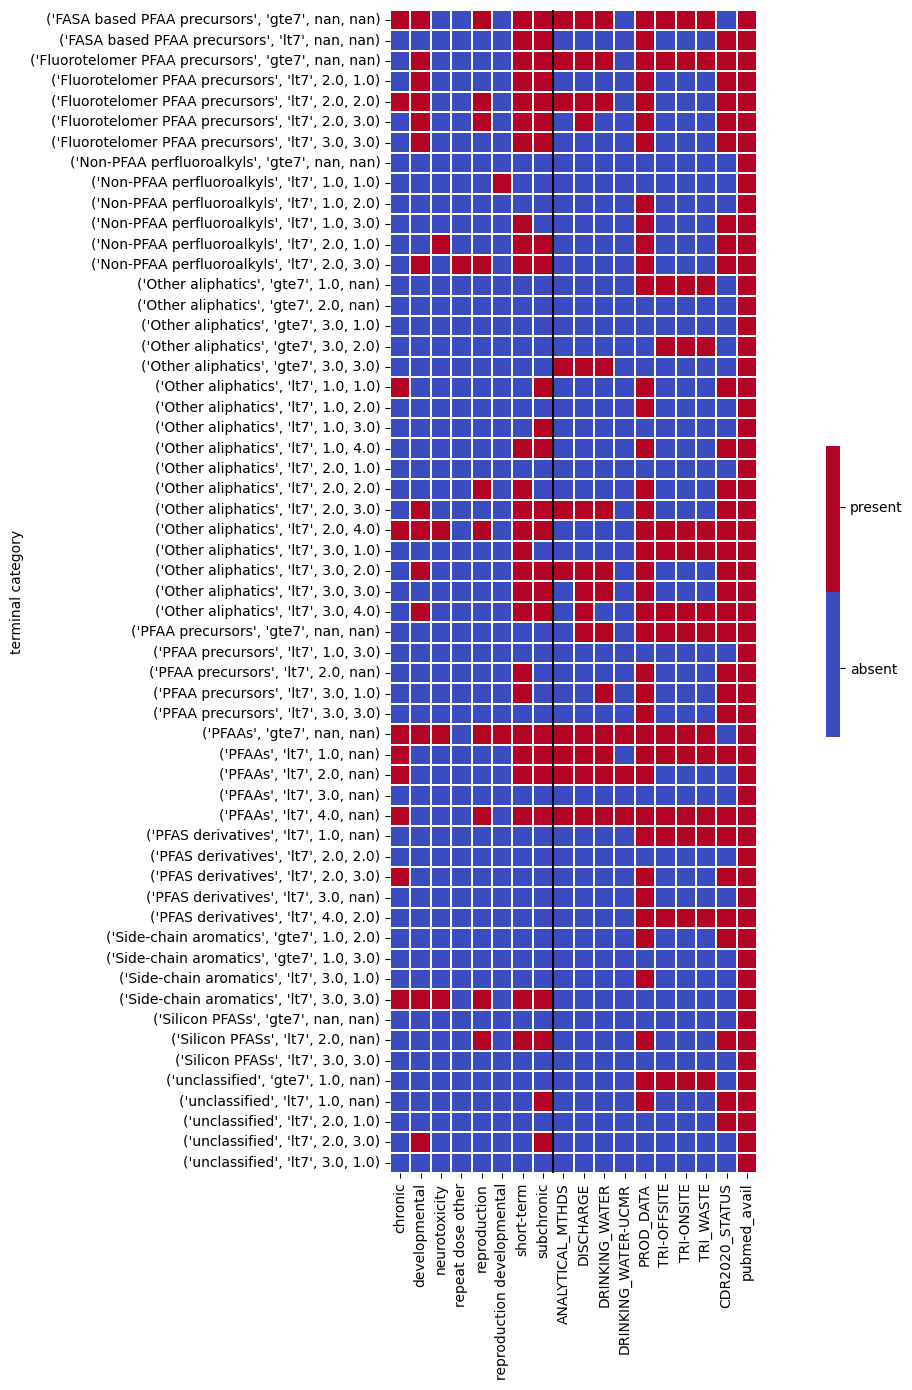

In [108]:
import matplotlib as mpl
f, ax = plt.subplots(figsize=(14, 14))
#labels = X2.index

my_colors=["blue", "red"]
cmap = mpl.cm.get_cmap('coolwarm', 2)
#bounds = [1,2]
#f.colorbar(mpl.cm.ScalarMappable(cmap = cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N)))
g = sns.heatmap(X2, cmap = cmap, vmin = 0.9, vmax = .2,  cbar_kws={"shrink": 0.25}, square = True,xticklabels='auto', yticklabels='auto', linewidths = 0.3, ax = ax)

colorbar = ax.collections[0].colorbar
#print(colorbar)
M=X2.max().max()
#print(M)
colorbar.set_ticks([0.35*M,0.75*M])
colorbar.set_ticklabels(['absent','present'])
#colorbar.ax.set_aspect(0.15)


#g.set_yticks(np.arange(len(X2.index)))
#g.set_yticklabels([''] +labels, fontsize = 8)
g.set_ylabel('terminal category')
#g.set_yticks(range(len(X1))
#g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 8)
ax.vlines([8], *ax.get_ylim(), color = 'k')
plt.tight_layout()
f.savefig(figures_dir+'Figure15_091123.png', dpi = 300);